# Regresión Lineal

En este cuaderno vamos a entrar más en detalle de cómo entrenar un modelo. En concreto vamos a aprender algunos pasos (pseudo)obligatorios a realizar cuando durante el entrenamiento:

 - Normalización o _standardization_ de las variables continuas
 - Dicotomización o _One-hot-encoding_ o variables _dummy_
 - División de los datos en conjunto de entrenamiento y conjunto de validación
 


Antes de empezar importamosm los datos con los que trabajaremos

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={"figure.figsize": (15.,8.)})

from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler, MinMaxScaler

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((sum(y_true) - sum(y_pred)) / sum(y_true))) * 100  


In [52]:
df = pd.read_csv('../Data/Modelos ML/Fish.csv', sep = ',')
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [67]:
df.Species.value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

# Variables _dummy_

Las variables explicativas de un modelo pueden ser tanto continuas como discretas. Incluso en muchos casos se discretizan todas para analizar de manera más fácil y detallada el comportamiento en todos los rangos del dominio. 

El proceso de crear las variables dummy consiste en crear una serie de variables binarias (indicadoras, one-hot encoding). Crearemos tantas variables como categorías tenga la variable original. Cada una de estas variables tomará 1 ó 0 en caso de que esa observación tomara o no ese valor en la categoria. 

### Qué ocurre si no creamos las variables dummy?

En primer lugar estas categorías deberían ser numéricas, si no python da error. De cualquier modo, incluirlas tal cual causaría que el modelo interprete que hay una relación ordinal entre las categorías (lo cual es incorrecto en variables discretas nominales). No daría error técnico, los métodos de scikit learn funcionarían sin problema, sin embargo no obtendríamos un buen modelo. El modelo podría dar coeficientes que parecen significativos, pero no representan relaciones reales. Ya que podría atribuir una tendencia que no existe en la realidad.



In [54]:
def fish_species(x):
    if x == 'Perch':
        return 'Perch'
    elif x == 'Bream':
        return 'Bream'
    else:
        return 'Others'

df['fish_species'] = df['Species'].apply(fish_species)    
df

,Species,Weight,Length1,Length2,Length3,Height,Width,fish_species
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,Bream
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,Bream
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,Bream
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,Bream
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,Bream
...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936,Others
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690,Others
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558,Others
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672,Others


In [55]:
df_dum = pd.get_dummies(df.fish_species)
df_dum = df_dum.astype(int)
df_dum.head()

,Bream,Others,Perch
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [56]:
df = pd.concat([df, df_dum], axis = 1)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,fish_species,Bream,Others,Perch
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,Bream,1,0,0
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,Bream,1,0,0
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,Bream,1,0,0
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,Bream,1,0,0
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,Bream,1,0,0


# Conjunto de entrenamiento y conjunto de validación

En primer lugar vamos a recordar el objetivo final de realizar un modelo predictivo, sea de regresión, clasificación, reconocimiento de imágenes o redes neuronales. Esto afecta a cualquier tipo de modelo estadístico supervisado. Se definen, dependiendo del tipo de modelo, una serie de coeficientes, pesos o reglas, entre otras, a través de un conjunto de datos que se conocen. Para después **usar ese aprendizaje en datos futuros y obtener las predicciones**.

En segundo lugar, cabe recordar las métricas de error o precisión que se han visto y su importancia para determinar si un modelo es apropiado.

Entonces, una acción básica y obligatoria para el entrenamiento de modelos es dividir el conjunto de datos en 2 subconjuntos. Uno será utilizado para entrenar el modelo en sí mismo, encontrar esos coeficientes y reglas de decisión que optimizan la predicción. El segundo subconjunto servirá para validar y comprender si el modelo entrenado es bueno y funciona adecuadamente. Normalmente, por cenvenio, el 80% de los datos serán usados para el entrenamiento, y el 20% restante para la validación.

### Qué ocurre si no usamos 2 conjuntos de datos diferentes para entrenar y validar?

Validar un modelo con los datos con los que los que se ha entrenado es incorrecto. El principal problema que podemos encontrar entrenando y validando el modelo con los mismos datos es sobreajustar el modelo (overfitting). Esto significa que tu modelo es muy bueno para hacer predicciones sobre los datos de entrenamiento, los cuales conoce perfectamente, pero que sin embargo en datos futuros o desconocidos puede fallar.

En otras palabras, tu modelo está demasiado diseñado/centrado en sus datos originales y puede no ser potente para predecir futuras observaciones. Estas futuras observaciones son desconocidas, de ahí que lo mejor sea validar tu modelo con observaciones ajenas también.



Por lo tanto, vamos a dividir nuestro dataset en dos, uno de entrenamiento y otro de validación. Normalmente la proporción es 80%-20% respectivamente. De forma que, construyamos el modelo con "train" y calculemos los errores (MAE, MSE y RMSE) con el de "test"

https://tech.gobetech.com/15376/cual-es-la-diferencia-entre-los-datos-de-entrenamiento-y-los-datos-de-prueba.html#:~:text=La%20salida%20de%20los%20datos%20de%20entrenamiento%20est%C3%A1,son%20m%C3%A1s%20grandes%20que%20los%20datos%20de%20prueba.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df[['Length1', 'Length2', 'Length3', 'Height', 'Width','Bream','Perch']], 
                                                    df['Weight'], test_size=0.2, random_state=0)

In [32]:
print(X_train.shape)
print(X_test.shape)

(127, 7)
(32, 7)


# Standardization

Este proceso es altamente recomendado cuando nuestras variables explicativas son continuas y tienen escalas o unidades de medida muy diferentes, por ejemplo cuando una de ellas se mide en centenas y otra en millares.

### Qué ocurre si no normalizamos estas variables?

El proceso de normalización de las variables continuas tiene como resultado que todos los valores de todas las variables continuas se encuentren centradas en el valor 0 y que su desviación típica sea 1. Es decir, la mayoría de observaciones están en torno a -1 y 1. No están limitadas a estos dos valores, de hecho el dominio sigue siendo infinito, pero sí hemos conseguido que estas variables se midan en unidades y que estén mayormente concentradas entre estos dos valores.

Si no llevamos a cabo este proceso corremos el riesgo de que las variables continuas que, por su naturaleza, toman valores más altos tomen más importancia en la predicción de la variable objetivo. Sin que esta importancia sea real o significativa. Por ejemplo, si tenemos las variables salario, medida en miles de €, y distancia al puesto de trabajo, medida en decenas de km.

Como hemos visto anteriormente, cada una de las variables explicativas es multiplicada por un coeficiente. Si una variable se toma valores mucho mayores al resto, ante coeficientes similares, tendrá mayor peso en la predicción final.

### Cómo llevamos a cabo la normalización?

Primeramente calculamos la media de la variable a tipificar. A continuación, a cada una de las observaciones de dicha variable se le es restada la media. De manera que la media de esta nueva variable es 0. Tendremos valores positivos y negativos, independientemente de la naturaleza de la variable original.

Posteriormente se divide cada observación por la desviación típica de la variable original. De este modo tenemos que la mayoría de individuos tomando valores entre -1 y 1.

$$\frac{X_i - Mean(X)}{std(X)}$$

### Existe otro método de estandarización de variables continuas?

Sí, varios. Otro muy común es min-max. Este método trata de concentrar todos los valores entre 0 y 1. Siendo que las observaciones que tomaron el valor máximo, ahora tomen el valor 1. Análogamente con los mínimos y el 0.

Se realiza restándole a cada observación el valor mínimo, y dividiéndolo entre la diferencia entre el máximo y el mínimo.

$$\frac{X_i - Min(X)}{Max(X) - Min(X)}$$


Gracias a la normalización optimizamos el entrenamiento del modelo y facilitamos la interpretación.

La tipificación solo se aplica en modelo multivariables, es decir con más de una variable explicativa.


### Las variables continuas del conjunto de validación se estandarizan usando los parámetros Media y desviación típica del conjunto de entrenamiento



In [72]:
scaler = StandardScaler()
scale_train = scaler.fit(X_train[['Length1', 'Length2', 'Length3', 'Height','Width']])

X_train[['Length1_st', 'Length2_st', 'Length3_st', 'Height_st',
         'Width_st']] = scaler.transform(X_train[['Length1', 'Length2', 'Length3', 'Height','Width']])

X_test[['Length1_st', 'Length2_st', 'Length3_st', 'Height_st',
         'Width_st']] = scaler.transform(X_test[['Length1', 'Length2', 'Length3', 'Height','Width']])

X_train

,Length1,Length2,Length3,Height,Width,Bream,Perch,Length1_st,Length2_st,Length3_st,Height_st,Width_st
143,56.0,60.0,64.0,9.6000,6.1440,0,0,3.170918,3.139044,2.989534,0.165693,1.083663
130,32.7,35.0,38.8,5.9364,4.3844,0,0,0.732809,0.700467,0.734117,-0.672600,0.025189
16,30.4,33.0,38.3,14.8604,5.2854,1,0,0.492137,0.505381,0.689367,1.369361,0.567179
96,22.0,24.0,25.5,7.2930,3.7230,0,1,-0.386838,-0.372507,-0.456242,-0.362187,-0.372671
107,26.9,28.7,30.1,7.5852,4.6354,0,1,0.125897,0.085945,-0.044539,-0.295327,0.176176
...,...,...,...,...,...,...,...,...,...,...,...,...
9,28.5,30.7,36.2,14.2266,4.9594,1,0,0.293321,0.281032,0.501415,1.224337,0.371076
103,25.4,27.5,28.9,7.1672,4.3350,0,1,-0.031062,-0.031106,-0.151940,-0.390972,-0.004527
67,19.0,20.7,23.2,9.3960,3.4104,0,0,-0.700758,-0.694399,-0.662094,0.119014,-0.560713
117,36.5,39.0,41.4,11.1366,6.0030,0,1,1.130440,1.090639,0.966819,0.517293,0.998845


In [20]:
minmax = MinMaxScaler()
df[['Length1_MM']] = minmax.fit_transform(df[['Length1']])
# data['belly_MM'] = minmax.fit_transform(data[['belly']])
df

,Species,Weight,Length1,Length2,Length3,Height,Width,Length1_MM
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,0.304854
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,0.320388
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,0.318447
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,0.365049
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0.368932
...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936,0.077670
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690,0.081553
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558,0.089320
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672,0.110680


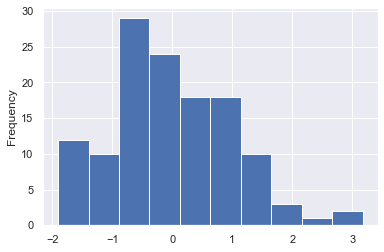

In [22]:
X_train['Length1_st'].plot(kind='hist');

# Entrenamiento del modelo

In [73]:
X_train = X_train[['Bream', 'Perch',
       'Length1_st', 'Length2_st', 'Length3_st', 'Height_st', 'Width_st']]

X_test = X_test[['Bream', 'Perch',
       'Length1_st', 'Length2_st', 'Length3_st', 'Height_st', 'Width_st']]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 7 to 90
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bream       32 non-null     int32  
 1   Perch       32 non-null     int32  
 2   Length1_st  32 non-null     float64
 3   Length2_st  32 non-null     float64
 4   Length3_st  32 non-null     float64
 5   Height_st   32 non-null     float64
 6   Width_st    32 non-null     float64
dtypes: float64(5), int32(2)
memory usage: 1.8 KB


In [74]:
X_train = sm.add_constant(X_train)
result = sm.OLS(y_train, X_train).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     144.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           4.55e-55
Time:                        17:56:27   Log-Likelihood:                -774.25
No. Observations:                 127   AIC:                             1564.
Df Residuals:                     119   BIC:                             1587.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        376.7956     20.127     18.721      0.0

In [75]:
prediction_train = result.predict(X_train)
X_test = sm.add_constant(X_test)
prediction_test = result.predict(X_test)
prediction_test.head()

7      487.524835
40     168.585370
95     198.875246
45     174.779263
110    651.190131
dtype: float64

In [76]:
print('MAE test', metrics.mean_absolute_error(y_test,prediction_test) )
print('MSE test' , metrics.mean_squared_error(y_test,prediction_test))
print('RMSE test', np.sqrt(metrics.mean_squared_error(y_test, prediction_test)))
print("MAPE: ", mean_absolute_percentage_error(y_test, prediction_test))
print("R2: ", metrics.r2_score(y_test, prediction_test))


MAE test 99.17774652309211
MSE test 26636.577496366943
RMSE test 163.20716129008233
MAPE:  3.1590670956091755
R2:  0.8600657372046472
